<a href="https://colab.research.google.com/github/jugash/Tools/blob/master/storypoints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install np
# !pip install pd
# !pip install nltk
# !pip install gensim

In [2]:
%cd /content/drive/MyDrive/DataScience/MSC/Project1/

/content/drive/MyDrive/DataScience/MSC/Project1


In [41]:
import numpy as np
import pandas as pd
import nltk
from gensim.models import Word2Vec
from gensim.models import FastText
from nltk import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
from keras.models import Sequential, Model
from keras import layers
from tensorflow.keras.layers import Dense, LSTM, Embedding,Dropout,SpatialDropout1D,Conv1D,MaxPooling1D,GRU,BatchNormalization
from tensorflow.keras.layers import Input,Bidirectional,GlobalAveragePooling1D,GlobalMaxPooling1D,concatenate,LeakyReLU, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc


embedding_dim=300
maxlen=100

nltk.download('punkt')

LABELS=['Trivial','Minor','Medium', 'Major', 'Huge','Enormous','Epic']
PROJECTS = ['appcelerator', 'aptanastudio', 'bamboo', 'clover', 'datamanagement', 'duracloud', 'jirasoftware', 'mesos', 'mule', 'mulestudio', 'springxd', 'talendesb', 'titanium']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
for prj in PROJECTS:
  if not os.path.exists(f'{prj}.csv'):
    !wget https://raw.githubusercontent.com/SEAnalytics/datasets/master/storypoint/IEEE%20TSE2018/Deep-SE/data/{prj}.csv


In [5]:
def load_files(projects=PROJECTS):
  dfs = []
  for prj in PROJECTS:
    df=pd.read_csv(f'{prj}.csv')
    df['project'] = prj
    dfs.append(df)
  return pd.concat(dfs)

df=load_files()
df=df.loc[df['storypoint'] < 20.5]

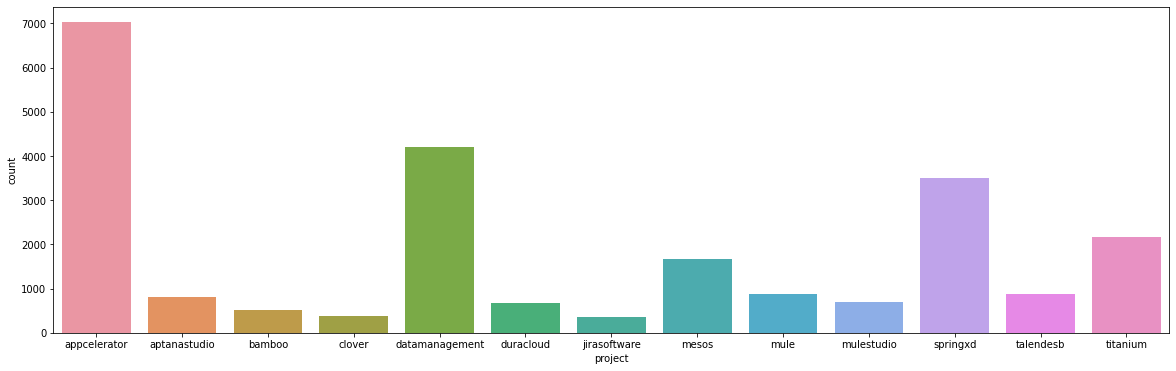

In [6]:
plt.figure(figsize=(20,6))

sns.countplot(data=df, x='project')

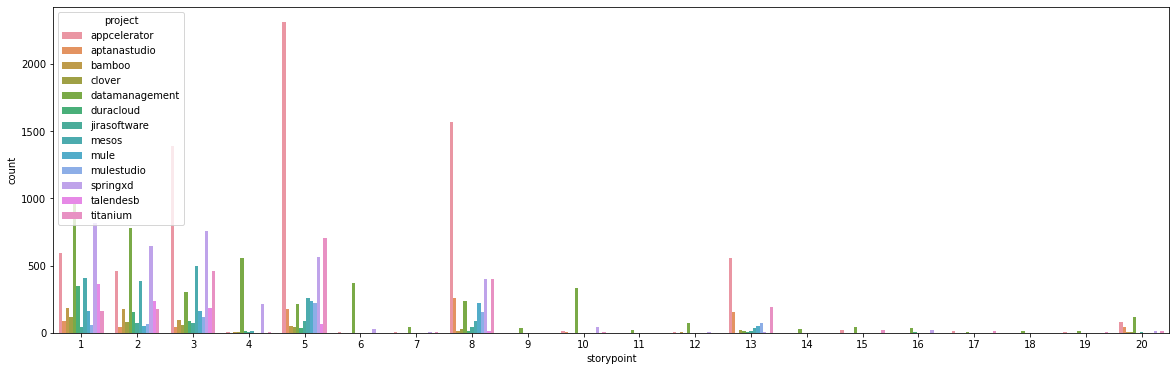

In [7]:
plt.figure(figsize=(20,6))
sns.countplot(data=df, x='storypoint', hue='project')

In [8]:
df['description']=df['description'].replace(np.nan, '', regex=True)

In [9]:
df['complexity'] = pd.cut(df['storypoint'], bins=[0.5,1.5,2.5,3.5,5.5,8.5,13.5,20.5], labels=LABELS)

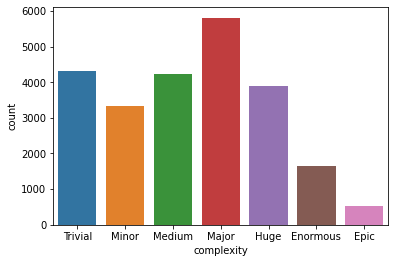

In [10]:
sns.countplot(data=df, x='complexity')

In [12]:
column = 'description'
fname = f'FT-{column}.txt'

Sentences=[word_tokenize(words) for words in df[column] ]

In [15]:
# model = FastText(Sentences, size=embedding_dim, window=5, min_count=1, workers=4, sg=0)
# model.wv.save_word2vec_format(fname, fvocab = 'Vocab')

In [16]:
labels = df['complexity'].values
sentences = df[column].values

#categorical_labels = to_categorical(labels, num_classes=7)
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, labels, test_size = 0.25, random_state=1000)

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [17]:
tokenizer = Tokenizer(num_words=13000, lower=True)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1

In [18]:
def pad_repeat(A, size=100):
  return np.vstack([np.resize(A[i], size) for i in range(len(A))])

X_train=pad_repeat(X_train,maxlen)
X_test=pad_repeat(X_test,maxlen)

In [45]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix


#uploaded=files.upload()
embedding_matrix = create_embedding_matrix(fname, tokenizer.word_index, embedding_dim)

In [46]:
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=False))

model.add(layers.Conv1D(100, kernel_size=3, kernel_regularizer=regularizers.l2(0.00001), padding='same'))
model.add(layers.LeakyReLU(alpha=0.2))
model.add(layers.MaxPool1D(pool_size=2))
model.add(SpatialDropout1D(0.5))
model.add(Bidirectional(LSTM(100,dropout=0.5, recurrent_dropout=0.5)))

model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(len(LABELS),activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          18802200  
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 100)          90100     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 50, 100)           0         
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 50, 100)           0         
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 200)               160800    
_________________________________________________________________
dense (Dense)                (None, 10)                2

In [ ]:
history = model.fit(X_train, y_train,
                    epochs=150,
                    verbose=True,
                    validation_split=0.2,
                    batch_size=128,
                    callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath = f'models/{column}_20210724', monitor='val_accuracy', mode='max', save_best_only=True)])

Epoch 1/150
112/112 [==============================] - 92s 616ms/step - loss: 1.8762 - accuracy: 0.2313 - val_loss: 1.8088 - val_accuracy: 0.2548
INFO:tensorflow:Assets written to: models/description_20210724/assets
Epoch 2/150
112/112 [==============================] - 69s 616ms/step - loss: 1.8170 - accuracy: 0.2374 - val_loss: 1.8044 - val_accuracy: 0.2609
INFO:tensorflow:Assets written to: models/description_20210724/assets
Epoch 3/150
112/112 [==============================] - 70s 627ms/step - loss: 1.8104 - accuracy: 0.2380 - val_loss: 1.7963 - val_accuracy: 0.2531
Epoch 4/150
112/112 [==============================] - 70s 627ms/step - loss: 1.8041 - accuracy: 0.2424 - val_loss: 1.7928 - val_accuracy: 0.2595
Epoch 5/150
112/112 [==============================] - 70s 622ms/step - loss: 1.7977 - accuracy: 0.2365 - val_loss: 1.7950 - val_accuracy: 0.2649
INFO:tensorflow:Assets written to: models/description_20210724/assets
Epoch 6/150
112/112 [==============================] - 69s 6

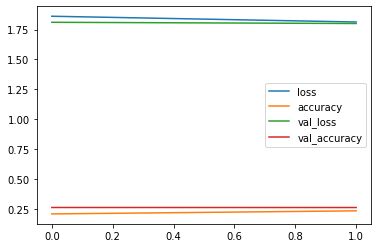

In [261]:
pd.DataFrame(history.history).plot()

In [19]:
model = tf.keras.models.load_model("models/description_all")

In [20]:
y_pred = model.predict(X_test)

In [21]:
OUT=pd.concat([pd.Series(sentences_test, name='title'), pd.Series(lb.inverse_transform(y_test), name='true'), pd.Series(lb.inverse_transform(y_pred), name='pred')], axis=1)

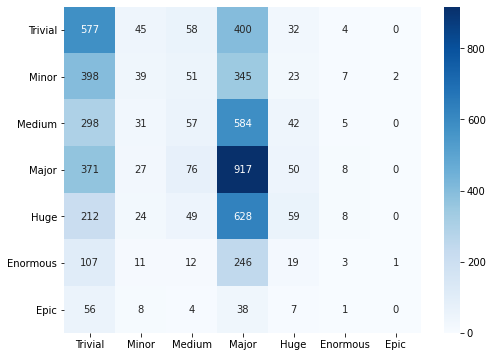

In [25]:
from sklearn.metrics import confusion_matrix


plt.figure(figsize=(8,6))
cm=confusion_matrix(OUT['true'], OUT['pred'], labels=LABELS )
sns.heatmap(cm, xticklabels=LABELS, yticklabels=LABELS, annot=True, cmap='Blues', fmt='')

In [26]:
def make_cls_df(y_test, predictions):
  cls=classification_report(y_test, predictions, output_dict=True)
  cls_df=pd.DataFrame(cls)
  # cls_df.columns=[*LABELS, 'accuracy', 'macro avg', 'weighted avg']
  return cls_df.T

In [27]:
make_cls_df(OUT['true'], OUT['pred'])

,precision,recall,f1-score,support
Enormous,0.083333,0.007519,0.013793,399.000000
Epic,0.000000,0.000000,0.000000,114.000000
Huge,0.254310,0.060204,0.097360,980.000000
Major,0.290374,0.632850,0.398090,1449.000000
Medium,0.185668,0.056047,0.086103,1017.000000
Minor,0.210811,0.045087,0.074286,865.000000
Trivial,0.285785,0.517025,0.368102,1116.000000
accuracy,0.278114,0.278114,0.278114,0.278114
macro avg,0.187183,0.188390,0.148248,5940.000000
weighted avg,0.234569,0.278114,0.208817,5940.000000


In [31]:
def plot_pr(y_test, predictions):
  precision, recall, thresholds = precision_recall_curve(y_test, predictions)
  pr_auc=auc(recall, precision)
  plt.plot(recall, precision, marker='.', label='Precision-Recall', color='g', alpha=0.7)
  plt.set_title(f'pr_auc=%.3f' % (pr_auc),  {'fontsize' : '18'})

def plot_roc(y_test, predictions):
  fpr,tpr,thresholds = roc_curve(y_test, predictions)
  try:
    roc_auc=roc_auc_score(y_test, predictions)
  except ValueError:
    roc_auc=1.0

  plt.plot(fpr, tpr, marker='.', label='ROC', color='r', alpha=0.7)
  plt.set_title(f'\n roc_auc=%.3f' % (roc_auc),  {'fontsize' : '18'})

In [42]:
def plot_pr(y_test, predictions, cols):
    n_rows = 2
    n_cols = 4 

    def plot_auc_one(y_i_test, predictions_i, label, ax):
      precision, recall, thresholds = precision_recall_curve(y_i_test, predictions_i)
      pr_auc=auc(recall, precision)
      ax.plot(recall, precision, marker='.', label='Precision-Recall', color='g', alpha=0.7)
      ax.set_title(f'{label[:12]}\n pr_auc=%.3f' % (pr_auc),  {'fontsize' : '18'})

    fig,axs=plt.subplots(n_rows, n_cols, figsize=(28,8))
    
    for i in range(y_test.shape[1]):
      plot_auc_one(y_test[:, i], predictions[:, i],  cols[i], axs[i//n_cols,i%n_cols])

    for i in range(len(cols), n_rows * n_cols):
      fig.delaxes(axs[i//n_cols, i%n_cols])
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig('pr-curve.jpg')
    plt.show()
    plt.close()

def plot_roc(y_test, predictions, cols):
    n_rows = 2
    n_cols = 4

    def plot_auc_one(y_i_test, predictions_i, label, ax):
      fpr,tpr,thresholds = roc_curve(y_i_test, predictions_i)
      try:
        roc_auc=roc_auc_score(y_i_test, predictions_i)
      except ValueError:
        roc_auc=1.0

      ax.plot(fpr, tpr, marker='.', label='ROC', color='r', alpha=0.7)
      ax.set_title(f'{label[:12]}\n roc_auc=%.3f' % (roc_auc),  {'fontsize' : '18'})

    fig,axs=plt.subplots(n_rows, n_cols, figsize=(28,8))
    
    for i in range(y_test.shape[1]):
      plot_auc_one(y_test[:, i], predictions[:, i],  cols[i], axs[i//n_cols,i%n_cols])

    for i in range(len(cols), n_rows * n_cols):
      fig.delaxes(axs[i//n_cols, i%n_cols])
    
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    plt.savefig('roc-curve.jpg')
    plt.show()
    plt.close()

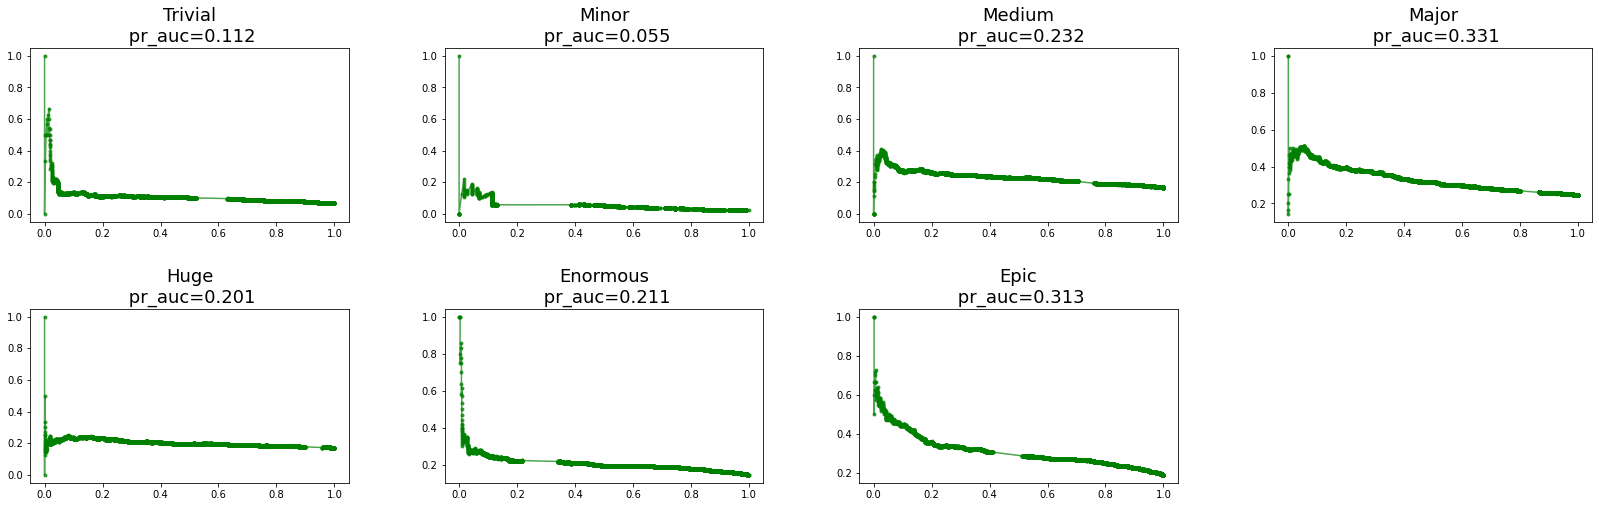

In [43]:
plot_pr(y_test, y_pred, LABELS)

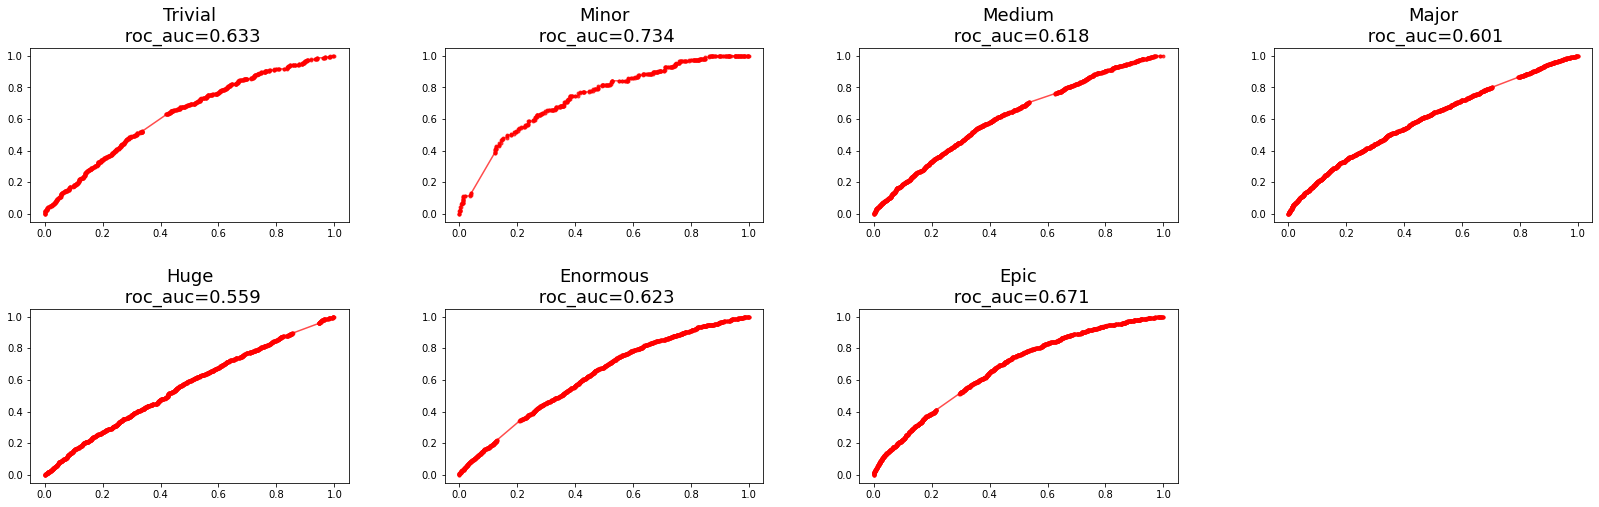

In [44]:
plot_roc(y_test, y_pred, LABELS)